In [1]:
import numpy as np
import random

# generate data

In [2]:
# In real world, you cannot learn how the data was generated. So do not rely on this function when coding your lab.
def generate_data(dim, num):
    x = np.random.normal(0, 10, [num, dim])
    coef = np.random.uniform(-1, 1, [dim, 1])
    pred = np.dot(x, coef)
    pred_n = (pred - np.mean(pred)) / np.sqrt(np.var(pred))
    label = np.sign(pred_n)
    mislabel_value = np.random.uniform(0, 1, num)
    mislabel = 0
    for i in range(num):
        if np.abs(pred_n[i]) < 1 and mislabel_value[i] > 0.9 + 0.1 * np.abs(pred_n[i]):
            label[i] *= -1
            mislabel += 1
    return x, label, mislabel/num

In [3]:
# example
np.random.seed(0)
x, y, mr = generate_data(5, 100)


In [4]:
x[:5], y[:5]

(array([[ 17.64052346,   4.00157208,   9.78737984,  22.40893199,
          18.6755799 ],
        [ -9.7727788 ,   9.50088418,  -1.51357208,  -1.03218852,
           4.10598502],
        [  1.44043571,  14.54273507,   7.61037725,   1.21675016,
           4.43863233],
        [  3.33674327,  14.94079073,  -2.05158264,   3.13067702,
          -8.54095739],
        [-25.52989816,   6.53618595,   8.64436199,  -7.4216502 ,
          22.69754624]]),
 array([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.]]))

# write your model class

In [5]:
# you can do anything necessary about the model
class SVM1:
    def __init__(self, dim, C=1, plot=True):
        """
        You can add some other parameters, which I think is not necessary
        """
        self.dim = dim
        self.C = C # 优化目标中损失函数前面的参数，设置太大会导致模型震荡难以收敛
        self.plot = plot # 是否输出图像

    def grad(self, X, y):
        temp = 1 - (X @ self.w) * y
        # 在max内部的值大于0时，才计算对应项的导数
        flag = np.array(np.frompyfunc(lambda x: 1.0 if x >
                        0 else 0.0, 1, 1)(temp), np.float64)
        return self.w - (self.C * (y.T @ (flag * X))).T

    def loss(self, X, y):
        temp = 1 - (X @ self.w) * y
        flag = np.array(np.frompyfunc(lambda x: 1.0 if x >
                        0 else 0.0, 1, 1)(temp), np.float64)
        return (0.5 * (self.w.T @ self.w) + self.C * np.sum((flag * temp).flatten()))[0][0]

    def iteration(self, X, y):
        # 步长较大时会反复震荡，因此将步长设为0.00001
        return 0.00001 * self.grad(X, y)

    def fit(self, X, y, tol=1e-2, max_iter=1e2):
        """
        Fit the coefficients via your methods
        """
        self.w = np.zeros((self.dim, 1))
        loss_table = []
        before = after = 0
        iter = 0
        # 通过前后两次迭代的损失函数值的差值来判断是否收敛
        while iter == 0 or (iter < max_iter and np.absolute(before - after) > tol):
            before = after
            self.w -= self.iteration(X, y)
            after = self.loss(X, y)
            iter += 1
            loss_table.append(after)
        if self.plot:
            from matplotlib import pyplot as plt
            plt.title('loss curve of training')
            plt.xlabel('iteration')
            plt.ylabel('loss')
            plt.plot(np.arange(1, iter + 1), np.array(loss_table).flatten())
            plt.show()

    def predict(self, X):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """
        # 计算预测值，并映射到±1
        return np.array(np.frompyfunc(lambda x: 1.0 if x > 0 else -1.0, 1, 1)(X @ self.w), np.float64)

    def score(self, X, y):
        result = self.predict(X)
        delta = np.array(np.frompyfunc(lambda x: 1.0 if x ==
                                       0 else 0.0, 1, 1)(result-y), np.float64)
        num = np.sum(delta)
        return num / delta.shape[0]


In [6]:
# you can do anything necessary about the model

class SVM2:
    def __init__(self, dim, C=100, plot=True, fit_intercept=False):
        """
        You can add some other parameters, which I think is not necessary
        """
        self.dim = dim
        self.C = C # 优化目标中损失函数前面的参数
        self.plot = plot # 是否输出图像
        self.w_max = 0 # 用于记录最大的w
        self.score_max = 0 # 用于记录最大的score
        self.b = 0
        self.fit_intercept = fit_intercept # 是否需要计算截距

    def update(self, X, y):
        self.w = np.sum(y * self.alpha * X, axis=0).reshape(self.dim, 1)
        self.E = X @ self.w - y # 计算预测值与理论值的误差，用于计算alpha
        if self.fit_intercept:
            self.E += self.b
        self.r = self.E * y # 计算误差与标签的乘积，用于计算alpha，在此处全部计算，而不是在计算alpha时再计算，是为了减少计算量

    def select(self, X, y, j):
        self.delta = self.E - self.E[j][0] # 计算误差的差值
        self.delta = np.maximum(self.delta, - self.delta) # 计算差值的绝对值
        return np.argmax(self.delta, axis=0)[0] # 返回最大差值对应的下标

    def error(self, X, y):
        # 用训练集上的错误率计算代替计算损失函数，计算损失函数所需计算量较大，而错误率可以用每次迭代的结果self.w来计算
        result = self.score(X, y)
        # 在迭代时发现会过拟合，因此在迭代时记录最大的score，并记录当时的self.w
        if result > self.score_max:
            self.score_max = result
            self.w_max = self.w
        return result

    def takestep(self, X, y, i, j, tol=1e-3):
        if i == j:
            return False
        # 计算alpha的上下界
        if y[i][0] != y[j][0]:
            L = max(0, self.alpha[j][0] - self.alpha[i][0])
            H = min(self.C, self.C + self.alpha[j][0] - self.alpha[i][0])
        else:
            L = max(0, self.alpha[i][0] + self.alpha[j][0] - self.C)
            H = min(self.C, self.alpha[i][0] + self.alpha[j][0])
        if L == H:
            return False
        newj = self.alpha[j][0] + y[j][0] * (self.E[i][0] - self.E[j][0]) / (
            X[i] @ X[i].T + X[j] @ X[j].T - 2 * (X[i] @ X[j].T))
        if newj < L:
            newj = L
        if newj > H:
            newj = H
        # 当alpha的变化量小于阈值时，不更新，加快迭代速度
        if abs(newj - self.alpha[j][0]) < tol:
            return False
        newi = self.alpha[i][0] + y[i][0] * \
            y[j][0] * (self.alpha[j][0] - newj)
        if self.fit_intercept:
            newbi = -self.E[i][0] - y[i][0] * (newi - self.alpha[i][0]) * (X[i] @ X[i].T) - y[j][0] * (
                newj - self.alpha[j][0]) * (X[i] @ X[j].T) + self.b
            newbj = -self.E[j][0] - y[i][0] * (newi - self.alpha[i][0]) * (X[i] @ X[j].T) - y[j][0] * (
                newj - self.alpha[j][0]) * (X[j] @ X[j].T) + self.b
            self.b = (newbi + newbj) / 2
        (self.alpha[i][0], self.alpha[j][0]) = (newi, newj)
        self.update(X, y)
        return True

    def examine(self, X, y, j, tol=1e-1):
        # 当alpha[j]满足KKT条件时，不更新，在这里引入阈值tol，允许alpha[j]与KKT条件不完全符合，以加快迭代速度
        if (self.r[j] < -tol and self.alpha[j] < self.C) or (self.r[j] > tol and self.alpha[j] > 0):
            if self.alpha[j] > 1:
                # 选择与alpha[j]误差最大的alpha[i]进行更新
                i = self.select(X, y, j)
                if self.takestep(X, y, i, j):
                    return 1
            temp = list(range(y.shape[0]))
            random.shuffle(temp)
            # 前面更新失败时选择的alpha[i]可能不是最优的，因此随机选择在边界上的alpha[i]进行更新
            for i in temp:
                if self.alpha[i] != 0 or self.alpha[i] != self.C:
                    if self.takestep(X, y, i, j):
                        return 1
            random.shuffle(temp)
            # 仍然失败时，随机选择alpha[i]进行更新
            for i in temp:
                if self.takestep(X, y, i, j):
                    return 1
        return 0

    def fit(self, X, y, max_iter=1e3):
        """
        Fit the coefficients via your methods
        """
        random.seed(0)
        self.alpha = np.zeros(y.shape)
        self.update(X, y)
        error_table = []
        iter = 0
        numChanged = 0
        examineAll = 1
        # 没有可更新的alpha时，迭代结束
        while iter < max_iter and (numChanged > 0 or examineAll == 1):
            numChanged = 0
            if examineAll == 1:
                # 遍历所有样本，对每个样本进行检查
                for j in range(y.shape[0]):
                    numChanged += self.examine(X, y, j)
                    iter += 1
                    error_table.append(self.error(X, y))
                    if iter == max_iter:
                        break
            else:
                # 遍历所有在边界上的样本，对每个样本进行检查
                for j in range(y.shape[0]):
                    if self.alpha[j] != 0 or self.alpha[j] != self.C:
                        numChanged += self.examine(X, y, j)
                        iter += 1
                        error_table.append(self.error(X, y))
                        if iter == max_iter:
                            break
            if examineAll == 1:
                examineAll = 0
            elif numChanged == 0:
                examineAll = 1
        self.w = self.w_max
        if self.plot:
            from matplotlib import pyplot as plt
            plt.title('error ratio of training')
            plt.xlabel('iteration')
            plt.ylabel('error ratio')
            plt.plot(np.arange(1, iter + 1), np.array(error_table).flatten())
            plt.show()

    def predict(self, X):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """
        # 计算预测值，并映射到±1
        return np.array(np.frompyfunc(lambda x: 1.0 if x > 0 else -1.0, 1, 1)(X @ self.w + (self.b if self.fit_intercept else 0)), np.float64)

    def score(self, X, y):
        result = self.predict(X)
        delta = np.array(np.frompyfunc(lambda x: 1.0 if x ==
                                       0 else 0.0, 1, 1)(result-y), np.float64)
        num = np.sum(delta)
        return num / delta.shape[0]


# construct and train your models

mislabel:0.0349


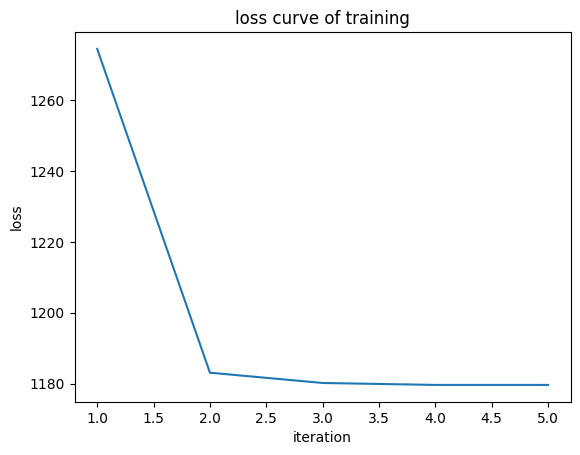

accuracy:0.9592


In [14]:
# generate data
dim, num = (20, 10000)
np.random.seed(0)
X_data, y_data, mislabel = generate_data(dim, num)
print('mislabel:{}'.format(mislabel))

# split data
# 训练集：测试集 = 3:1
train_index = set(np.random.choice(num, int(num / 4 * 3), replace=False))
test_index = set(range(num)) - train_index
(train, test) = (np.array(list(train_index)), np.array(list(test_index)))
(X_train, y_train) = (X_data[train], y_data[train])
(X_test, y_test) = (X_data[test], y_data[test])

# constrcut model and train (remember record time)
model1 = SVM1(dim)
model1.fit(X_train, y_train)
print('accuracy:{:.4f}'.format(model1.score(X_test, y_test)))


mislabel:0.0349


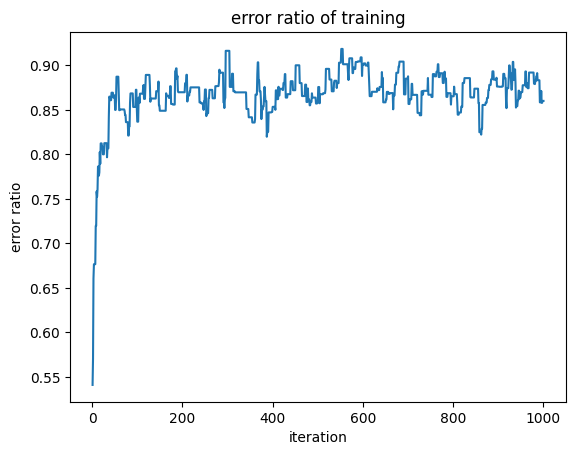

accuracy:0.9216


In [8]:
# generate data
dim, num = (20, 10000)
np.random.seed(0)
X_data, y_data, mislabel = generate_data(dim, num)
print('mislabel:{}'.format(mislabel))

# split data
# 训练集：测试集 = 3:1
train_index = set(np.random.choice(num, int(num / 4 * 3), replace=False))
test_index = set(range(num)) - train_index
(train, test) = (np.array(list(train_index)), np.array(list(test_index)))
(X_train, y_train) = (X_data[train], y_data[train])
(X_test, y_test) = (X_data[test], y_data[test])

# constrcut model and train (remember record time)
model1 = SVM2(dim)
model1.fit(X_train, y_train)
print('accuracy:{:.4f}'.format(model1.score(X_test, y_test)))


# predict and compare your results

In [9]:
# sklearn (20维 10000样本数据集)
from sklearn.svm import LinearSVC

# generate data
dim, num = (20, 10000)
np.random.seed(0)
X_data, y_data, mislabel = generate_data(dim, num)
print('mislabel:{}'.format(mislabel))

# split data
train_index = set(np.random.choice(num, int(num / 4 * 3), replace=False))
test_index = set(range(num)) - train_index
(train, test) = (np.array(list(train_index)), np.array(list(test_index)))
(X_train, y_train) = (X_data[train], y_data[train])
(X_test, y_test) = (X_data[test], y_data[test])

# constrcut model and train (remember record time)
modelSVM = LinearSVC(fit_intercept=0, dual=False)
modelSVM.fit(X_train, y_train.flatten())
print('accuracy:{:.4f}'.format(modelSVM.score(X_test, y_test)))


mislabel:0.0349
accuracy:0.9588


In [10]:
# 四折交叉验证
from sklearn.svm import LinearSVC

dim, num = (20, 10000)
np.random.seed(0)
X_data, y_data, mislabel = generate_data(dim, num)
data = np.c_[X_data, y_data]
print('mislabel:{}'.format(mislabel))

# 正负两类样本拆分
positive = data[(y_data == 1.0).flatten(), :]
negative = data[(~(y_data == 1.0)).flatten(), :]
pn = positive.shape[0]
nn = negative.shape[0]
modelSVM_acc = []
model1_acc = []
model2_acc = []
modelSVM = LinearSVC(fit_intercept=0, dual=False)
model1 = SVM1(dim, plot=False)
model2 = SVM2(dim, plot=False)
for i in range(4):
    # 样本打乱
    np.random.shuffle(positive)
    np.random.shuffle(negative)
    for i in range(4):
        test_index_p = set(range(i * int(pn / 4), (i + 1) * int(pn / 4)))
        train_index_p = set(range(pn)) - test_index_p
        (train_p, test_p) = (positive[np.array(
            list(train_index_p)), :], positive[np.array(list(test_index_p)), :])
        test_index_n = set(range(i * int(nn / 4), (i + 1) * int(nn / 4)))
        train_index_n = set(range(nn)) - test_index_n
        (train_n, test_n) = (negative[np.array(
            list(train_index_n)), :], negative[np.array(list(test_index_n)), :])
        (train, test) = (np.r_[train_p, train_n], np.r_[test_p, test_n])
        (X_train, y_train) = (train[:, :-1], train[:, -1:])
        (X_test, y_test) = (test[:, :-1], test[:, -1:])
        modelSVM.fit(X_train, y_train.flatten())
        model1.fit(X_train, y_train)
        model2.fit(X_train, y_train)
        modelSVM_acc.append(modelSVM.score(X_test, y_test.flatten()))
        model1_acc.append(model1.score(X_test, y_test))
        model2_acc.append(model2.score(X_test, y_test))
print('sklearn accuracy:{:.4f}'.format(sum(modelSVM_acc) / len(modelSVM_acc)))
print('model1 accuracy:{:.4f}'.format(sum(model1_acc) / len(model1_acc)))
print('model2 accuracy:{:.4f}'.format(sum(model2_acc)/len(model2_acc)))


mislabel:0.0349
sklearn accuracy:0.9592
model1 accuracy:0.9590
model2 accuracy:0.9216
